In [1]:
from typing import List
from Dataset.CustomDataset import AgeGroupAndAgeDataset, StandardDataset, AgeGroupAndAgeDatasetKL
from Dataset.CustomDataLoaders import CustomDataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from Utils import AAR, CSVUtils, AgeConversion
from Utils.Validator import Validator

c:\Users\Gio\.conda\envs\AV_project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Caricamento del dataframe
df = CSVUtils.get_df_from_csv("./training_caip_contest.csv", "./training_caip_contest/")

#Suddivisione del dataframe in 3 age groups
_, label_map = CSVUtils.get_df_with_age_subdivision(df, 3)

In [3]:
df_train, df_val = train_test_split(df, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# def transform_image(image: Image):
#     _image = (np.array(image.resize((224, 224))) / 255.0).transpose(2, 0, 1).astype(np.float32)
#     # From: https://github.com/pytorch/examples/blob/main/imagenet/main.py
#     _image[0] = (_image[0] - 0.485)/0.229
#     _image[1] = (_image[1] - 0.456)/0.224
#     _image[2] = (_image[2] - 0.406)/0.225
#     return _image

from torchvision import transforms
import torch

transform_func = transforms.Compose([
    transforms.Resize(224),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    # transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.RandomGrayscale(),
])

transform_func_val = transforms.Compose([
    transforms.Resize(224),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

#Implementazione di un Dataset utilizzando "CustomDataset" per l'architettura con Film
# label_map = {x: (0 if x <= 20 else (2 if x >= 60 else 1)) for x in range(1, 82)}
cd_train = AgeGroupAndAgeDatasetKL(df_train, path_col="path", label_col="age", label_function="CAE", 
                                   label_map=label_map, label_map_n_classes=3, transform_func=transform_func)

cd_val = StandardDataset(df_val, path_col="path", label_col="age", label_function="CAE", transform_func=transform_func_val)
cd_val.set_n_classes(81)
cd_val.set_starting_class(1)

dm_train = CustomDataLoader(cd_train)
dl_train = dm_train.get_unbalanced_dataloader(batch_size=128, shuffle=True, drop_last=True)

In [15]:
for d in dl_train:
    x, y = d
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


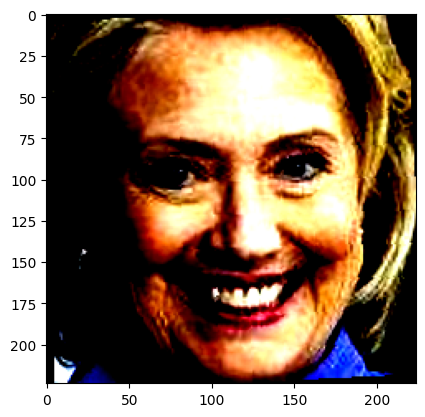

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x[0].numpy().transpose(1, 2, 0))

In [18]:
AgeConversion.EVAge(y[2])

tensor([29.0000, 17.0000, 38.0000, 51.0000, 45.0000, 22.0000, 31.0000, 39.0000,
        28.0000, 17.0000, 34.0000, 42.0000, 25.0000, 20.0000, 57.0000, 36.0000,
        34.0000, 38.0000, 31.0000, 46.0000, 50.0000, 60.0000, 61.0000, 60.0000,
        25.0000, 36.0000, 29.0000, 22.0000, 46.0000, 60.0000, 56.0000, 44.0000,
        33.0000, 64.0000, 19.0000, 40.0000, 64.0000, 42.0000, 28.0000, 49.0000,
        38.0000, 47.0000, 28.0000, 26.0000, 52.0000, 51.0000, 38.0000, 17.0000,
        61.0000, 25.0000, 58.0000, 50.0000, 42.0000, 34.0000, 37.0000, 29.0000,
        22.0000, 42.0000, 57.0000, 41.0000, 26.0000, 19.0000, 59.0000, 30.0000,
        23.0000, 21.0000, 33.0000, 20.0000, 18.0000, 53.0000, 26.0000, 27.0000,
        21.0000, 50.0000, 57.0000, 43.0000, 42.0000, 20.0000, 56.0000, 38.0000,
        15.0000, 28.0000, 39.0000, 48.0000, 27.0000, 25.0000, 50.0000, 48.0000,
        36.0000, 62.0000, 50.0000, 50.0000, 65.0000, 51.0000, 57.0000, 25.0000,
        32.0000, 41.0000, 22.0000, 54.00

In [4]:
from ResNetFilmed.resnet import ResNetFiLMed, BackBone, ResNetNotFiLMed, DoNothingLayer
from torchvision.models import resnet18, ResNet18_Weights
import torch
from torch import optim
import torch.nn.functional as F
from torch import nn

####################################################
EPOCHS = 24
####################################################

# backbone = BackBone(pretrained=True)
backbone = resnet18(ResNet18_Weights.IMAGENET1K_V1)
backbone.fc = DoNothingLayer()
# backbone.eval()
backbone.requires_grad_(False)
backbone.to("cuda")
# model_age_group = ResNetFiLMed(backbone, 3)
model_age = ResNetNotFiLMed(backbone, 81)
# opt = optim.Adam(set([*model_age_group.parameters(), *model_age.parameters()]), lr=1e-4)
# opt = optim.SGD(set([*model_age_group.parameters(), *model_age.parameters()]), lr=1e-1, weight_decay=1e-4)
opt = optim.SGD(set(model_age.fc0.parameters()), lr=1e-4, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.OneCycleLR(opt, 1e-2, steps_per_epoch=len(dl_train), epochs=EPOCHS)
cross_entropy = nn.CrossEntropyLoss()
kl = nn.KLDivLoss(reduction="batchmean")

c:\Users\Gio\.conda\envs\AV_project\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [5]:
validator = Validator(cd_val, AgeConversion.EVAge, 32, num_workers=8, prefetch_factor=4)

In [6]:
age_weight = 1/5

best_val_aar = -1
# knowledge_age_group = torch.tensor([[0.33, 0.33, 0.33]]*128, requires_grad=False).float().to("cuda")
for e in range(EPOCHS):
    with tqdm(dl_train, unit=" batch") as tepoch:
        for batch in tepoch:
            opt.zero_grad()
            x, y = batch
            x = x.to("cuda")
            # y = y.to("cuda")
            # y_age_group = y[0].to("cuda")
            y_age = y[1].to("cuda")
            y_age_kl: torch.Tensor = y[2].to("cuda")
            
            # knowledge = model_age_group(x, knowledge_age_group)
            # loss_age_group: torch.Tensor = cross_entropy(knowledge, y_age_group)

            # knowledge = F.softmax(knowledge, dim=-1)
            # out_age = model_age(x, knowledge)
            out_age = model_age(x)
            loss_age_kl: torch.Tensor = kl(F.log_softmax(out_age, dim=-1), y_age_kl)

            out = F.softmax(out_age, dim=-1)
            out = AgeConversion.EVAge(out)
            y_age = AgeConversion.EVAge(y_age)
            loss_age: torch.Tensor = torch.mean(torch.abs(out - y_age))

            # loss = loss_age_group*age_weight + loss_age + loss_age_kl
            loss = loss_age + loss_age_kl
            loss.backward()
            opt.step()
            # scheduler.step()

            tepoch.set_postfix(#loss_age_group=loss_age_group.detach().cpu().numpy(), 
                                loss_age=loss_age.detach().cpu().numpy(), 
                                loss_age_kl=loss_age_kl.detach().cpu().numpy())

    def forward_function(x):
        # knowledge_age_group = torch.tensor([[0.33, 0.33, 0.33]]*len(x), requires_grad=False).float().to("cuda")
        # knowledge = model_age_group(x, knowledge_age_group)
        # knowledge = F.softmax(knowledge, dim=-1)
        # out = model_age(x, knowledge)
        out = model_age(x)
        out = F.softmax(out, dim=-1)
        return out

    val_aar, val_aar_old = validator.validate(forward_function)
    print(val_aar, val_aar_old)

    if val_aar > best_val_aar:
        best_val_aar = val_aar
        # torch.save(model_age_group.state_dict(), "./model_age_group_unbalanced.pt")
        torch.save(model_age.state_dict(), "./model_age_unbalanced.pt")
        print("Saved model")

 69%|██████▉   | 2329/3369 [04:09<01:37, 10.66 batch/s, loss_age=7.74134960770607, loss_age_kl=3.1169669077898603]  

In [ ]:
# model_age_group.load_state_dict(torch.load("./model_age_group_unbalanced.pt"))
model_age.load_state_dict(torch.load("./model_age_unbalanced.pt"))
# torch.save(model_age_group.state_dict(), "./model_age_group_unbalanced.pt")
# torch.save(model_age.state_dict(), "./model_age_unbalanced.pt")

<All keys matched successfully>